## Objectives and takeaways
1. Take a real-world experiment, write the model.
2. Write a Metropolis sampler, including the proposal distribution.
3. Perform inference using your sampler

Remark: with thanks to Charles Lao for consulting on the structure of a suitable model.

## Experiment

We shall work with the experiment published in Belin and Rubin [1] in 1995 that analyzed reaction times to visual stimuli in Schizophrenia.

A total of 17 volunteers performed 30 repetitions of a visual task and their reaction time was measured in milliseconds. There were 6 schizophrenics and 11 healthy volunteers.

Note that in the work [1], the authors do not use a Bayesian approach for estimation but apply an EM procedure.  The priors that we define in this work must therefore be our construction.

Below is the original data from the experiment, available [here](http://www.stat.columbia.edu/~gelman/book/data/schiz.asc).

In [1]:
orig_data = """
312 272 350 286 268 328 298 356 292 308 296 372 396 402 280 330 254 282 350 328 332 308 292 258 340 242 306 328 294 272
354 346 384 342 302 312 322 376 306 402 320 298 308 414 304 422 388 422 426 338 332 426 478 372 392 374 430 388 354 368
256 284 320 274 324 268 370 430 314 312 362 256 342 388 302 366 298 396 274 226 328 274 258 220 236 272 322 284 274 356
260 294 306 292 264 290 272 268 344 362 330 280 354 320 334 276 418 288 338 350 350 324 286 322 280 256 218 256 220 356
204 272 250 260 314 308 246 236 208 268 272 264 308 236 238 350 272 252 252 236 306 238 350 206 260 280 274 318 268 210
590 312 286 310 778 364 318 316 316 298 344 262 274 330 312 310 376 326 346 334 282 292 282 300 290 302 300 306 294 444
308 364 374 278 366 310 358 380 294 334 302 250 542 340 352 322 372 348 460 322 374 370 334 360 318 356 338 346 462 510
244 240 278 262 266 254 240 244 226 266 294 250 284 260 418 280 294 216 308 324 264 232 294 236 226 234 274 258 208 380
232 262 230 222 210 284 232 228 264 246 264 316 260 266 304 268 384 234 308 266 294 254 222 262 278 290 208 232 206 206
318 324 282 364 286 342 306 302 280 306 256 334 332 336 360 344 480 310 336 314 392 284 292 280 320 322 286 406 352 324
240 292 350 254 396 430 260 320 298 312 290 248 276 364 318 434 400 382 318 298 298 248 250 234 280 306 282 234 424 244

276 272 264 258 278 286 314 340 334 364 286 344 312 380 262 324 310 260 280 262 364 316 270 286 326 302 300 302 344 290
374 466 432 376 360 454 478 382 524 410 520 470 514 354 434 380 416 384 462 386 404 362 420 360 390 356 550 372 386 396
594 1014 1586 1344 610 838 772 264 748 1076 446 314 304 1680 1700 334 256 422 302 296 354 322 276 382 502 428 544 286 650 432
402 466 296 348 680 702 500 500 576 624 406 378 586 826 298 882 564 656 716 380 448 506 1714 748 510 810 984 458 390 642
620 714 414 358 460 598 324 442 372 410 998 636 968 490 696 560 562 720 618 456 502 974 1032 470 462 798 716 300 586 574
454 388 344 226 562 766 502 432 608 516 500 796 542 458 448 404 372 524 400 366 374 350 1154 558 440 348 400 460 514 450"""

In [2]:
orig_data

'\n312 272 350 286 268 328 298 356 292 308 296 372 396 402 280 330 254 282 350 328 332 308 292 258 340 242 306 328 294 272\n354 346 384 342 302 312 322 376 306 402 320 298 308 414 304 422 388 422 426 338 332 426 478 372 392 374 430 388 354 368\n256 284 320 274 324 268 370 430 314 312 362 256 342 388 302 366 298 396 274 226 328 274 258 220 236 272 322 284 274 356\n260 294 306 292 264 290 272 268 344 362 330 280 354 320 334 276 418 288 338 350 350 324 286 322 280 256 218 256 220 356\n204 272 250 260 314 308 246 236 208 268 272 264 308 236 238 350 272 252 252 236 306 238 350 206 260 280 274 318 268 210\n590 312 286 310 778 364 318 316 316 298 344 262 274 330 312 310 376 326 346 334 282 292 282 300 290 302 300 306 294 444\n308 364 374 278 366 310 358 380 294 334 302 250 542 340 352 322 372 348 460 322 374 370 334 360 318 356 338 346 462 510\n244 240 278 262 266 254 240 244 226 266 294 250 284 260 418 280 294 216 308 324 264 232 294 236 226 234 274 258 208 380\n232 262 230 222 210 284 232 2

In [3]:
import numpy as np

# the first 11 lines are from controls, the last 6 from schizophrenics
def parse_data():
    rts, idx = [], 0
    for line in orig_data.split('\n'):
        if len(line) == 0: continue
        cat = 0 if idx < 11 else 1
        tokens = line.split(' ')
        rts.append(list(map(int, line.split(' '))))
    return np.array(rts)

reaction_times = parse_data()

In [4]:
reaction_times

array([[ 312,  272,  350,  286,  268,  328,  298,  356,  292,  308,  296,
         372,  396,  402,  280,  330,  254,  282,  350,  328,  332,  308,
         292,  258,  340,  242,  306,  328,  294,  272],
       [ 354,  346,  384,  342,  302,  312,  322,  376,  306,  402,  320,
         298,  308,  414,  304,  422,  388,  422,  426,  338,  332,  426,
         478,  372,  392,  374,  430,  388,  354,  368],
       [ 256,  284,  320,  274,  324,  268,  370,  430,  314,  312,  362,
         256,  342,  388,  302,  366,  298,  396,  274,  226,  328,  274,
         258,  220,  236,  272,  322,  284,  274,  356],
       [ 260,  294,  306,  292,  264,  290,  272,  268,  344,  362,  330,
         280,  354,  320,  334,  276,  418,  288,  338,  350,  350,  324,
         286,  322,  280,  256,  218,  256,  220,  356],
       [ 204,  272,  250,  260,  314,  308,  246,  236,  208,  268,  272,
         264,  308,  236,  238,  350,  272,  252,  252,  236,  306,  238,
         350,  206,  260,  280, 

In [5]:
Np, Nt = reaction_times.shape
print('Data shows %d patients, %d trials per patient' % (Np, Nt))

Data shows 17 patients, 30 trials per patient


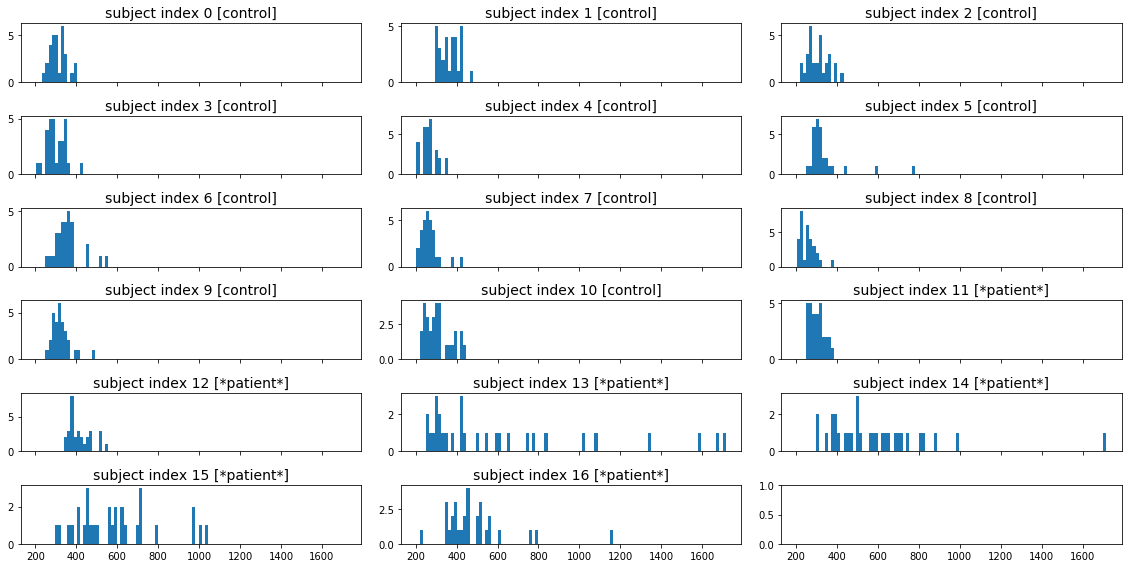

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

_, axes = plt.subplots(6, 3, figsize=(16, 8), sharex=True)
bins = np.linspace(reaction_times.min(), reaction_times.max(), 100)
axes = axes.flatten()
for isbj in range(Np):
    axes[isbj].hist(reaction_times[isbj, :], bins)
    axes[isbj].set_title('subject index %d [%s]' %(isbj, 'control' if isbj < 11 else '*patient*'), fontsize=14)
plt.tight_layout();

### Data description
Patients are stored in rows. For example data in line ```rts[0,:]``` shows reaction times in milliseconds for the first control group participant.

In [7]:
print(reaction_times[0,:])

[312 272 350 286 268 328 298 356 292 308 296 372 396 402 280 330 254 282
 350 328 332 308 292 258 340 242 306 328 294 272]


### Structure of solution
1. Select priors for the problem (see below).
2. Write down the structure of the model, write the ```log_prior``` and ```log_likelihood``` functions.
3. Write a proposal distribution, function ```proposal``` to suggest a new state from current state.
4. Write (or modify, from notebook 3f) the Metropolis sampler.
5. Sample outputs and evaluate.

## Working sampler using PyMC3

So that the structure of the model is clear, we provide a working example of a sampler using the PyMC3 library.

In [8]:
import pymc3 as pm
import theano.tensor as tt

/home/adam/anaconda3/envs/pymc_tutorial/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
with pm.Model() as schizo_model:
    mu = pm.Normal('mu', 400, 100)
    alphas_ = pm.Normal('alphas_', 0, 50., shape=(Np,1))
    alphas = pm.Deterministic('alphas', mu + alphas_)
    
    sigma_ctrl = pm.HalfNormal('sigma_ctrl', 100)
    sigma_pat = pm.HalfNormal('sigma_pat', 100)
    tau = pm.HalfNormal('tau', 100)
    
    lambdas = pm.Uniform('lambdas', 0., 1., shape=(6,1))
    Z = pm.Bernoulli('Z', lambdas, shape=(6, Nt))

    controls = pm.Normal('control',
                      alphas[:11,:],
                      sigma_ctrl,
                      observed=reaction_times[:11, :])

    patients = pm.Normal('patients',
                       alphas[11:,:] + Z*tau,
                       tt.switch(Z, sigma_pat, sigma_ctrl),
                       observed=reaction_times[11:,:])

In [10]:
with schizo_model:
    trace = pm.sample(draws=2000,
                      tune=1000,
                      chains=2)

/home/adam/anaconda3/envs/pymc_tutorial/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [Z]
>NUTS: [lambdas_interval__, tau_log__, sigma_pat_log__, sigma_ctrl_log__, alphas_, mu]
100%|█████████▉| 2999/3000 [01:35<00:00, 31.42it/s]/home/adam/anaconda3/envs/pymc_tutorial/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 3000/3000 [01:35<00:00, 31.41it/s]
/home/adam/anaconda3/envs/pymc_tutorial/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The est

In [11]:
pm.summary(trace, varnames=['mu', 'tau', 'lambdas', 'sigma_ctrl', 'sigma_pat'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,336.699231,12.201448,0.491217,313.498897,360.781280,495.0,1.000083
tau,268.826154,42.363913,0.891259,181.919708,348.873977,1902.0,0.999984
lambdas__0_0,0.037857,0.036730,0.000724,0.000004,0.107535,3325.0,0.999826
lambdas__1_0,0.046222,0.044790,0.000922,0.000009,0.138422,2399.0,0.999824
lambdas__2_0,0.618635,0.111554,0.002681,0.403176,0.829750,1913.0,1.000030
lambdas__3_0,0.720217,0.126619,0.004047,0.507781,0.994467,1010.0,0.999759
lambdas__4_0,0.746017,0.128304,0.004495,0.530756,0.999827,678.0,1.003689
lambdas__5_0,0.286996,0.106565,0.002500,0.093122,0.495880,1673.0,0.999783
sigma_ctrl,55.659311,2.021094,0.040843,51.718733,59.790873,2276.0,0.999808
sigma_pat,316.475591,25.498787,0.459663,266.868993,366.783977,2937.0,0.999944


# Your turn!
Now let's work on writing our own sampler.  While ```PyMC3``` uses a NUTS sampler plus Gibbs sampling for the latent variables $Z_{i,j}$, we will build the entire system using Metropolis and compare our results.

### Model structure
Below we discuss model similar to model number 4 from Belin and Rubin [1], their richest model. The other models are not discussed in this notebook.

In the following, we will use the subscript $i \in \{1, 2, ..., 17\}$ to denote participants and $j \in \{1, 2, ..., 30\}$ to denote trials, so for example $Y_{i,j}$ denotes observed reaction time for patient $i$ and trial $j$.

It is assumed that there is a mean reaction time $\mu$ and standard deviation $\sigma_1$ in the control group but each participant in the study can have a slightly different mean reaction time $\alpha_i$. Schizophrenic participants behave like the control group except in specific trials, where they exhibit an attention deficit that causes their reaction time to be increased.  The (unobserved) variable $Z_{i,j} \in \{0,1\}$ denotes whether the attention deficit was present $Z_{i,j}=1$ or absent $Z_{i,j}=0$ in trial $j$ for patient $i$. The proportion of trials $\lambda_i$ where the deficit manifests varies among patients.

We may formalize the model for the control group as follows:

$$Y_{i,j} \sim {\cal N}(\alpha_i, \sigma_1^2)$$

and for the schizophrenia group as

$$Y_{i,j} \sim {\cal N}(\alpha_i, \sigma_1^2),$$

if the trial had no attention deficit present (so exactly the same as control group) and

$$Y_{i,j} \sim {\cal N}(\alpha_i + \tau, \sigma_2^2),$$

if there was an attention deficit.  Note the different standard deviation used to model the reaction time under attention deficit.  In the model below, we use $Z_{i,j}$ to keep track of which mode is active in the trials performed by schizophrenic patients.  We additionally posit that 

$$\begin{array}{rcl}
\lambda_i &\sim& \text{U}(0,1) \\
Z_{i,j} &\sim& \text{Bernoulli}(\lambda_i), \\
\mu &\sim& {\cal N}(400, 100)\\
\Delta \alpha_i &\sim& {\cal N}(0, 50), \\
\alpha_i &=& \mu + \Delta \alpha_i \\
\tau &\sim& \text{HalfNormal}(50), \\
\sigma_1 &\sim& \text{HalfNormal}(100), \\
\sigma_2 &\sim& \text{HalfNormal}(100). \\
\end{array}$$

### Structure of state
Although as much freedom should be provided to write the code, there is a recommendation below on how to structure the state variable as a dictionary because it helps to improve the readability of the code.

### Final remarks
Thanks to Charles Lao for consulting on fitting model structure for this experiment.

 - Exploration step
 - Clipping vs bijection
 - Nice distribution at the end?

In [8]:
import numpy as np
import scipy.stats
import copy
import seaborn as sns

In [10]:
lambda_initial = 0.5
v_init = { 'mu' : 400,
           'delta_alphas': np.random.randn(Np) * 50,
           'tau': 50,
           'sigma_ctrl': 100,
           'sigma_pat': 100,
           'lambdas' : np.ones(6,) * lambda_initial,
           'Z': np.where(np.random.uniform(size=(6,Nt)) < lambda_initial, np.ones((6,Nt)), np.zeros((6,Nt)))
         }

In [11]:
def init_prior():
    lambdas = scipy.stats.uniform.rvs( 0., 1., size=6)
    return { 
        'mu' : scipy.stats.norm.rvs(400, 100, 1)[0],
        'delta_alphas': scipy.stats.norm.rvs(0, 50., size=Np),
        'tau': scipy.stats.halfnorm.rvs(0, 50),
        'sigma_ctrl': scipy.stats.halfnorm.rvs(0, 100),
        'sigma_pat': scipy.stats.halfnorm.rvs(0, 100),
        'lambdas' : lambdas,
        'Z': scipy.stats.bernoulli.rvs(lambdas, size=(Nt, 6)).T
    }

In [56]:
def update_state(state):
    state = copy.deepcopy(state)
    new_lambdas = np.clip(state['lambdas'] + np.random.randn(6) * 0.05, 0, 1) 
    state['mu'] = np.clip(state['mu'] + np.random.randn() * 20, 1, 10000)
    state['delta_alphas'] = state['delta_alphas'] + np.random.randn(Np) * 5
    state['tau'] = np.clip(state['tau'] + np.random.randn() * 5, 1, 10000)
    state['sigma_ctrl'] = np.clip(state['sigma_ctrl'] + np.random.randn() * 10, 1, 10000)
    state['sigma_pat'] = np.clip(state['sigma_pat'] + np.random.randn() * 10, 1, 10000)
    state['lambdas'] = new_lambdas
    state['Z'] = scipy.stats.bernoulli.rvs(new_lambdas, size=(Nt, 6)).T
    return state
    

In [23]:
def propose_unconstrained(r):
    if hasattr(r, 'shape'):
        return r + np.random.randn(*r.shape) * 0.1
    return r + np.random.randn()

def propose_0_1(value):
    # use m: (0,1) -> R
    r = np.tan(np.pi * (value - 0.5))
    # random walk proposal in unconstrained space
    r_star = propose_unconstrained(r)
    # use m^{-1}: R -> (0,1)
    return np.arctan(r_star) / np.pi + 0.5

# proposal for positive values
def propose_0_inf(value):
    # m: (0,+inf) -> R
    r = np.log(value)
    # random walk proposal in unconstrained space
    r_star = propose_unconstrained(r)
    # m^{-1}: R -> (0,1)
    return np.exp(r_star)

def update_state(state):
    state = copy.deepcopy(state)
    new_lambdas = propose_0_1(state['lambdas']) 
    state['mu'] = propose_0_inf(state['mu'])
    state['delta_alphas'] = state['delta_alphas'] + np.random.randn(Np)
    state['tau'] = propose_0_inf(state['tau'])
    state['sigma_ctrl'] = propose_0_inf(state['sigma_ctrl'])
    state['sigma_pat'] = propose_0_inf(state['sigma_pat'])
    state['lambdas'] = new_lambdas
    state['Z'] = scipy.stats.bernoulli.rvs(new_lambdas, size=(Nt, 6)).T
    return state

In [15]:
def log_data_likelyhood(reaction_times, state):
    alphas = state['delta_alphas'] + state['mu']
    alphas_ctrl = alphas[:11]
    alphas_pat = alphas[11:]

    sum_ctrl = 0
    for patient_id in range(11):
        sum_ctrl += np.sum(np.log(scipy.stats.norm.pdf(reaction_times[patient_id, :], alphas_ctrl[patient_id], state['sigma_ctrl'])))
    
    alphas_mix = state['Z'] * state['tau']  + alphas_pat.reshape((-1,1))
    sigma_mix = state['Z'] * state['sigma_pat'] + (1 - state['Z']) * state['sigma_ctrl']
    sum_pat = 0
    for patient_id in range(6):
        sum_pat += np.sum(np.log(scipy.stats.norm.pdf(reaction_times[11+patient_id, :], alphas_mix[patient_id], sigma_mix[patient_id])))
    
    return sum_pat + sum_ctrl

In [26]:
def log_prior(state):
    return np.sum([
        np.sum(np.log(scipy.stats.bernoulli.pmf(state['Z'].T, state['lambdas']))),
        np.sum(np.log(scipy.stats.norm.pdf(state['delta_alphas'], 0, 50.))),
        np.sum(np.log(scipy.stats.uniform.pdf(state['lambdas'], 0, 1))),
        np.sum(np.log(scipy.stats.norm.pdf(state['mu'], 400, 100))),
        np.sum(np.log(scipy.stats.halfnorm.pdf(state['sigma_ctrl'], 0, 100))),
        np.sum(np.log(scipy.stats.halfnorm.pdf(state['sigma_pat'], 0, 100))),
        np.sum(np.log(scipy.stats.halfnorm.rvs(state['tau'], 0, 50)))])


In [27]:
def model_log_posterior(reaction_times, state):
    return log_data_likelyhood(reaction_times, state) + log_prior(state)

In [28]:
def metropolis(state, n):
    act_state, act_log_p = state, model_log_posterior(reaction_times, state)
    states = []
    states.append(act_state)
    
    for i in range(1, n):
        new_state = update_state(states[-1])
        new_log_p = model_log_posterior(reaction_times, new_state)
        
        # draw uniform number
        u = np.random.uniform()
        if new_log_p - act_log_p > np.log(u):
            states.append(new_state)
            act_state, act_log_p = new_state, new_log_p
        else:
            # this is different from Monte Carlo rejection sampler
            # if we reject a new sample we 're-sample' the current state
            states.append(act_state)
            
    return states

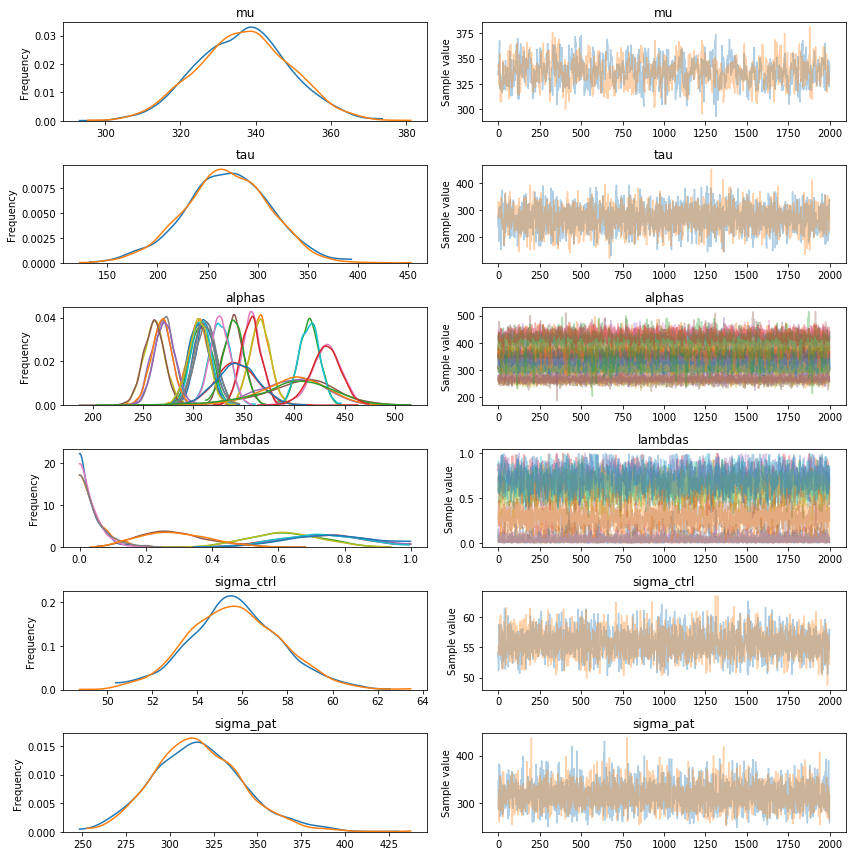

In [12]:
with schizo_model:
    _ = pm.traceplot(trace, varnames=['mu', 'tau', 'alphas', 'lambdas', 'sigma_ctrl', 'sigma_pat'])

In [57]:
states = metropolis(v_init, 70000)

/home/adam/.pyenv/versions/3.6.3/envs/3.6.3.bnb/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


In [58]:
def plot_univarient_distribution(states, key, history_size, axes=None):
    chosen_states = states[-history_size:]
    values = list(map(lambda state: state[key], chosen_states))
    print(np.mean(values), np.var(values))
    sns.distplot(values, ax=ax, bins=100)
    
def plot_multivariet_distribution(states, key, idx, history_size, axes=None):
    chosen_states = states[-history_size:]
    values = list(map(lambda state: state[key][idx], chosen_states))
    print(np.mean(values), np.var(values))
    sns.distplot(values, ax=ax, bins=100)


336.0869043178234 186.16254341185297


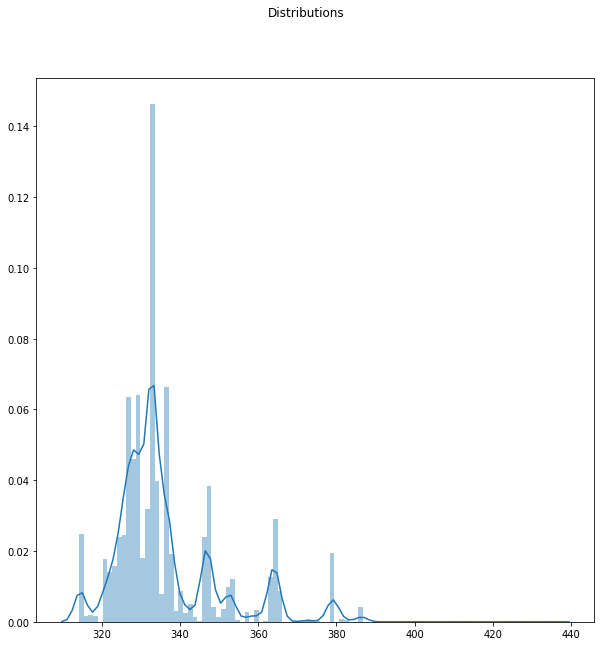

In [59]:
plt.figure(figsize=(10,10))
plt.suptitle("Distributions")
ax = plt.gca()
plot_univarient_distribution(states, key='mu', history_size=150000, axes=ax)


0.41934921577554374 0.19030743573332026
0.012395639129956131 0.0005191461923775224
0.8423798629867539 0.07995053914945653
0.8813753788409568 0.03995078535712906
0.6964868937335272 0.17683878558096391
0.9772062522625973 0.00196366516944192


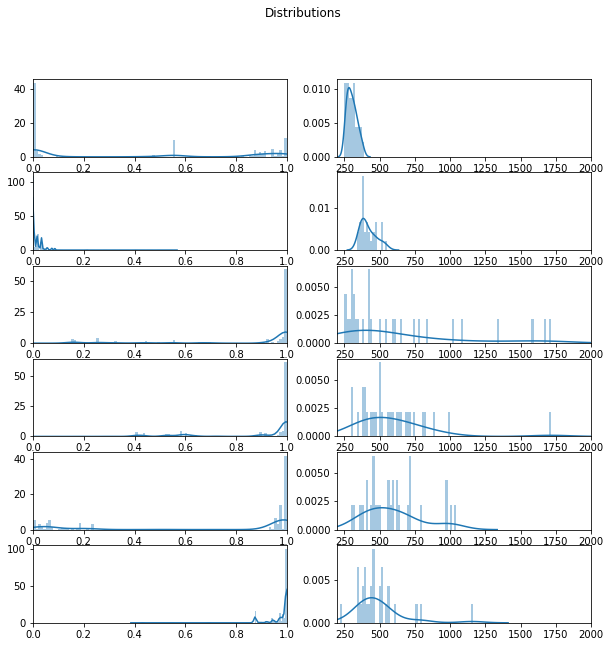

In [60]:
plt.figure(figsize=(10,10))
patient_bins = np.linspace(reaction_times.min(), reaction_times.max(), 100)

plt.suptitle("Distributions")
for patient_id in range(6):
    ax = plt.subplot(6,2, 2 * patient_id + 1)    
    ax.set_xlim([0, 1])
    plot_multivariet_distribution(states, key='lambdas', idx=patient_id, history_size=150000, axes=ax)
    ax = plt.subplot(6,2, 2 * patient_id + 2)
    ax.set_xlim([200, 2000])
    sns.distplot(reaction_times[11+patient_id], ax=ax, bins=patient_bins)
    


In [61]:
def get_alpha(state, idx):
    alphas = state['mu'] + state['delta_alphas']
    alphas_ctrl = alphas[:11]
    alphas_pat = alphas[11:]
    alphas_mix = state['Z'] * state['tau']  + alphas_pat.reshape((-1,1))
    return np.hstack([alphas_ctrl, np.mean(alphas_mix, axis=1)])[idx]


def plot_alpha_distribution(states, history_size, idx, ax=None):
    chosen_states = states[-history_size:]
    values = list(map(lambda state: get_alpha(state, idx), chosen_states))
    sns.distplot(values, ax=ax, bins=100)

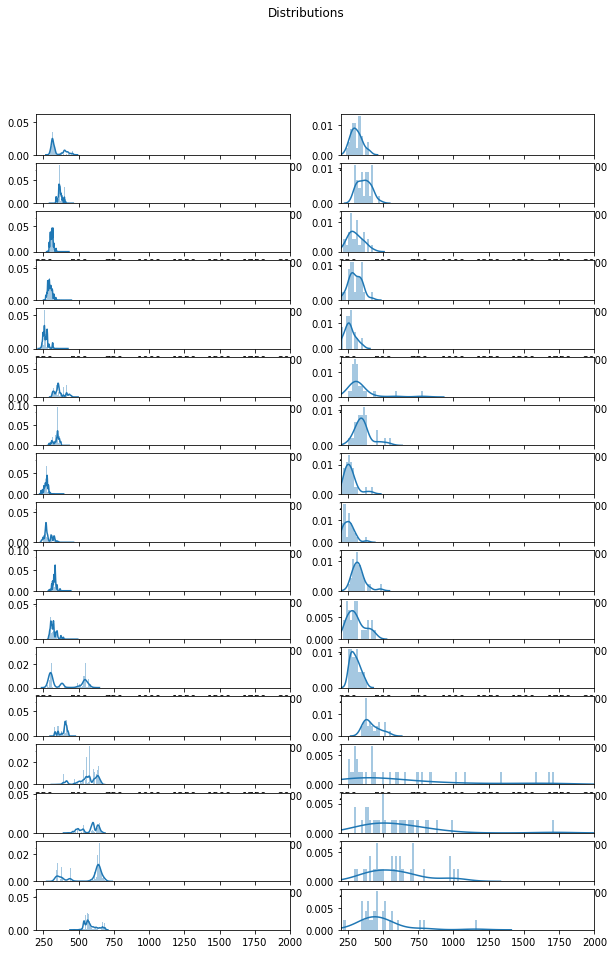

In [62]:
plt.figure(figsize=(10,15))
patient_bins = np.linspace(reaction_times.min(), reaction_times.max(), 100)

plt.suptitle("Distributions")
for patient_id in range(Np):
    ax = plt.subplot(Np, 2, 2 * patient_id + 1)    
    ax.set_xlim([200, 2000])
    plot_alpha_distribution(states, idx=patient_id, history_size=150000, ax=ax)
    ax = plt.subplot(Np, 2, 2 * patient_id + 2)
    ax.set_xlim([200, 2000])
    sns.distplot(reaction_times[patient_id], ax=ax, bins=patient_bins)